<a href="https://colab.research.google.com/github/Bmdhia/Rating_Predictions/blob/main/NYC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import set_config
set_config(transform_output='pandas')
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay,classification_report
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

In [4]:
df = pd.read_csv('/content/drive/MyDrive/DataSets/food_order.csv')
df.shape

(1898, 9)

In [5]:
def description(df):
 print(f"Dataset Shape: {df.shape}") #check numbers of rows and columns
 summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
 summary = summary.reset_index()
 summary['Name'] = summary['index']
 summary = summary[['Name','dtypes']] #check data types
 summary['Missing'] = df.isnull().sum().values #check missing values
 summary['Uniques'] = df.nunique().values #check unique values
 return summary

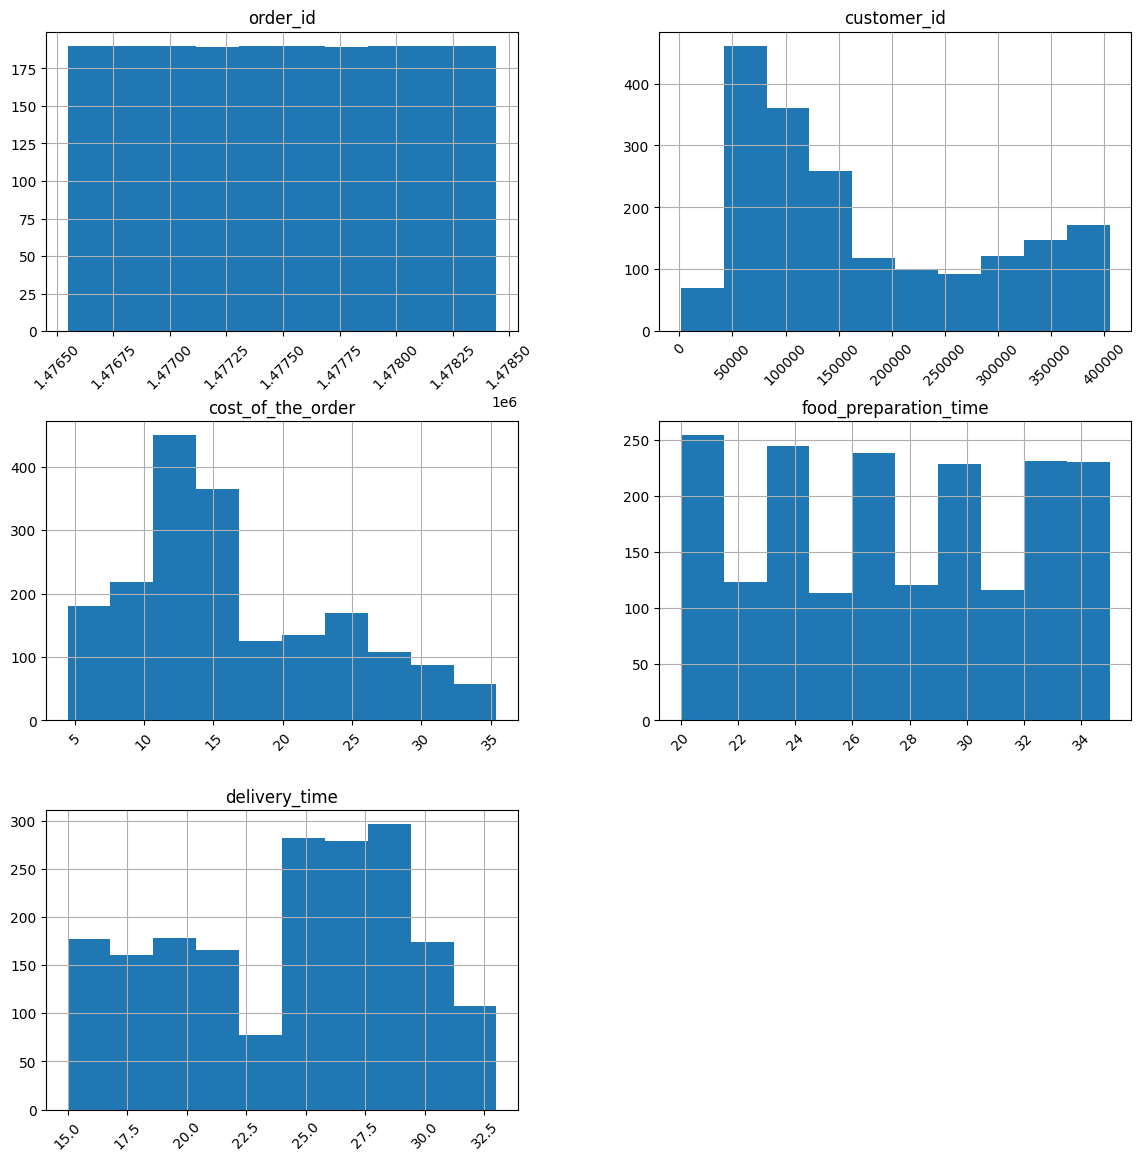

In [6]:
df.hist(figsize=(14,14), xrot=45)
plt.show()

In [8]:
df

,order_id,customer_id,restaurant_name,cuisine_type,cost_of_the_order,day_of_the_week,rating,food_preparation_time,delivery_time
0,1477147,337525,Hangawi,Korean,30.75,Weekend,Not given,25,20
1,1477685,358141,Blue Ribbon Sushi Izakaya,Japanese,12.08,Weekend,Not given,25,23
2,1477070,66393,Cafe Habana,Mexican,12.23,Weekday,5,23,28
3,1477334,106968,Blue Ribbon Fried Chicken,American,29.20,Weekend,3,25,15
4,1478249,76942,Dirty Bird to Go,American,11.59,Weekday,4,25,24
...,...,...,...,...,...,...,...,...,...
1893,1476701,292602,Chipotle Mexican Grill $1.99 Delivery,Mexican,22.31,Weekend,5,31,17
1894,1477421,397537,The Smile,American,12.18,Weekend,5,31,19
1895,1477819,35309,Blue Ribbon Sushi,Japanese,25.22,Weekday,Not given,31,24
1896,1477513,64151,Jack's Wife Freda,Mediterranean,12.18,Weekday,5,23,31


1. Source of data

     https://www.kaggle.com/datasets/ahsan81/food-ordering-and-delivery-app-dataset

2. Brief description of data

     Sample data from an online food ordering / delivery App of New York Restaurants

3. What is the target?

     rating

4. What does one row represent? (A person? A business? An event? A product?)

     food order

5. Is this a classification or regression problem?

     classification problem

6. How many features does the data have?

     9 features

7. How many rows are in the dataset?

     1898 rows


8. What, if any, challenges do you foresee in cleaning, exploring, or modeling this dataset?

     the dataset is imbalanced

Deleted unnecessary columns :

In [6]:
df.drop(columns=['order_id', 'customer_id'], inplace=True)

* I removed these two columns because they do not contribute to predicting the output.

In [10]:
df.duplicated().sum()

0

Identified and addressed missing values :

In [11]:
df.isna().sum()

restaurant_name          0
cuisine_type             0
cost_of_the_order        0
day_of_the_week          0
rating                   0
food_preparation_time    0
delivery_time            0
dtype: int64

In [12]:
df['rating'].value_counts(normalize=True)

Not given    0.387777
5            0.309800
4            0.203372
3            0.099052
Name: rating, dtype: float64

In [7]:
df = df[df['rating'] != 'Not given']

In [8]:
df['rating'].value_counts(normalize=True)

5    0.506024
4    0.332186
3    0.161790
Name: rating, dtype: float64

* I dropped missing values (Not given) to maintain data quality and ensure accurate analysis.

In [15]:
df['restaurant_name'].value_counts()

Shake Shack                    133
The Meatball Shop               84
Blue Ribbon Sushi               73
Blue Ribbon Fried Chicken       64
RedFarm Broadway                41
                              ... 
Philippe Chow                    1
Dirty Bird To Go (archived)      1
The MasalaWala                   1
Kambi Ramen House                1
'wichcraft                       1
Name: restaurant_name, Length: 156, dtype: int64

In [16]:
df['restaurant_name'].value_counts().unique().sum()

745

In [17]:
len(df['restaurant_name'].value_counts()[df['restaurant_name'].value_counts() == 1])

52

In [18]:
len(df['restaurant_name'].value_counts()[df['restaurant_name'].value_counts() == 2])

31

In [19]:
df['restaurant_name'].value_counts().unique().sum()

745

In [9]:
df = df[df['restaurant_name'].map(df['restaurant_name'].value_counts()) >= 3]

* I dropped values with a frequency less than 2 to reduce high cardinality.

In [21]:
df.shape

(1048, 7)

Identified and corrected inconsistencies in data for categorical values (i.e. Cat, cat, cats) :

In [22]:
cat = df.select_dtypes(include=['object']).columns
for column in cat:
    print(df[column].value_counts(), '\n')

Shake Shack                  133
The Meatball Shop             84
Blue Ribbon Sushi             73
Blue Ribbon Fried Chicken     64
RedFarm Broadway              41
                            ... 
Delicatessen                   3
L'Express                      3
Blue Ribbon Brooklyn           3
Sarabeth's East                3
Junoon                         3
Name: restaurant_name, Length: 73, dtype: int64 

American          343
Japanese          254
Italian           158
Chinese           124
Mexican            39
Indian             36
Mediterranean      31
Middle Eastern     29
Southern           11
French              8
Korean              5
Spanish             4
Thai                3
Vietnamese          3
Name: cuisine_type, dtype: int64 

Weekend    753
Weekday    295
Name: day_of_the_week, dtype: int64 

5    524
4    352
3    172
Name: rating, dtype: int64 



Produced univariate visuals for the target and all features :

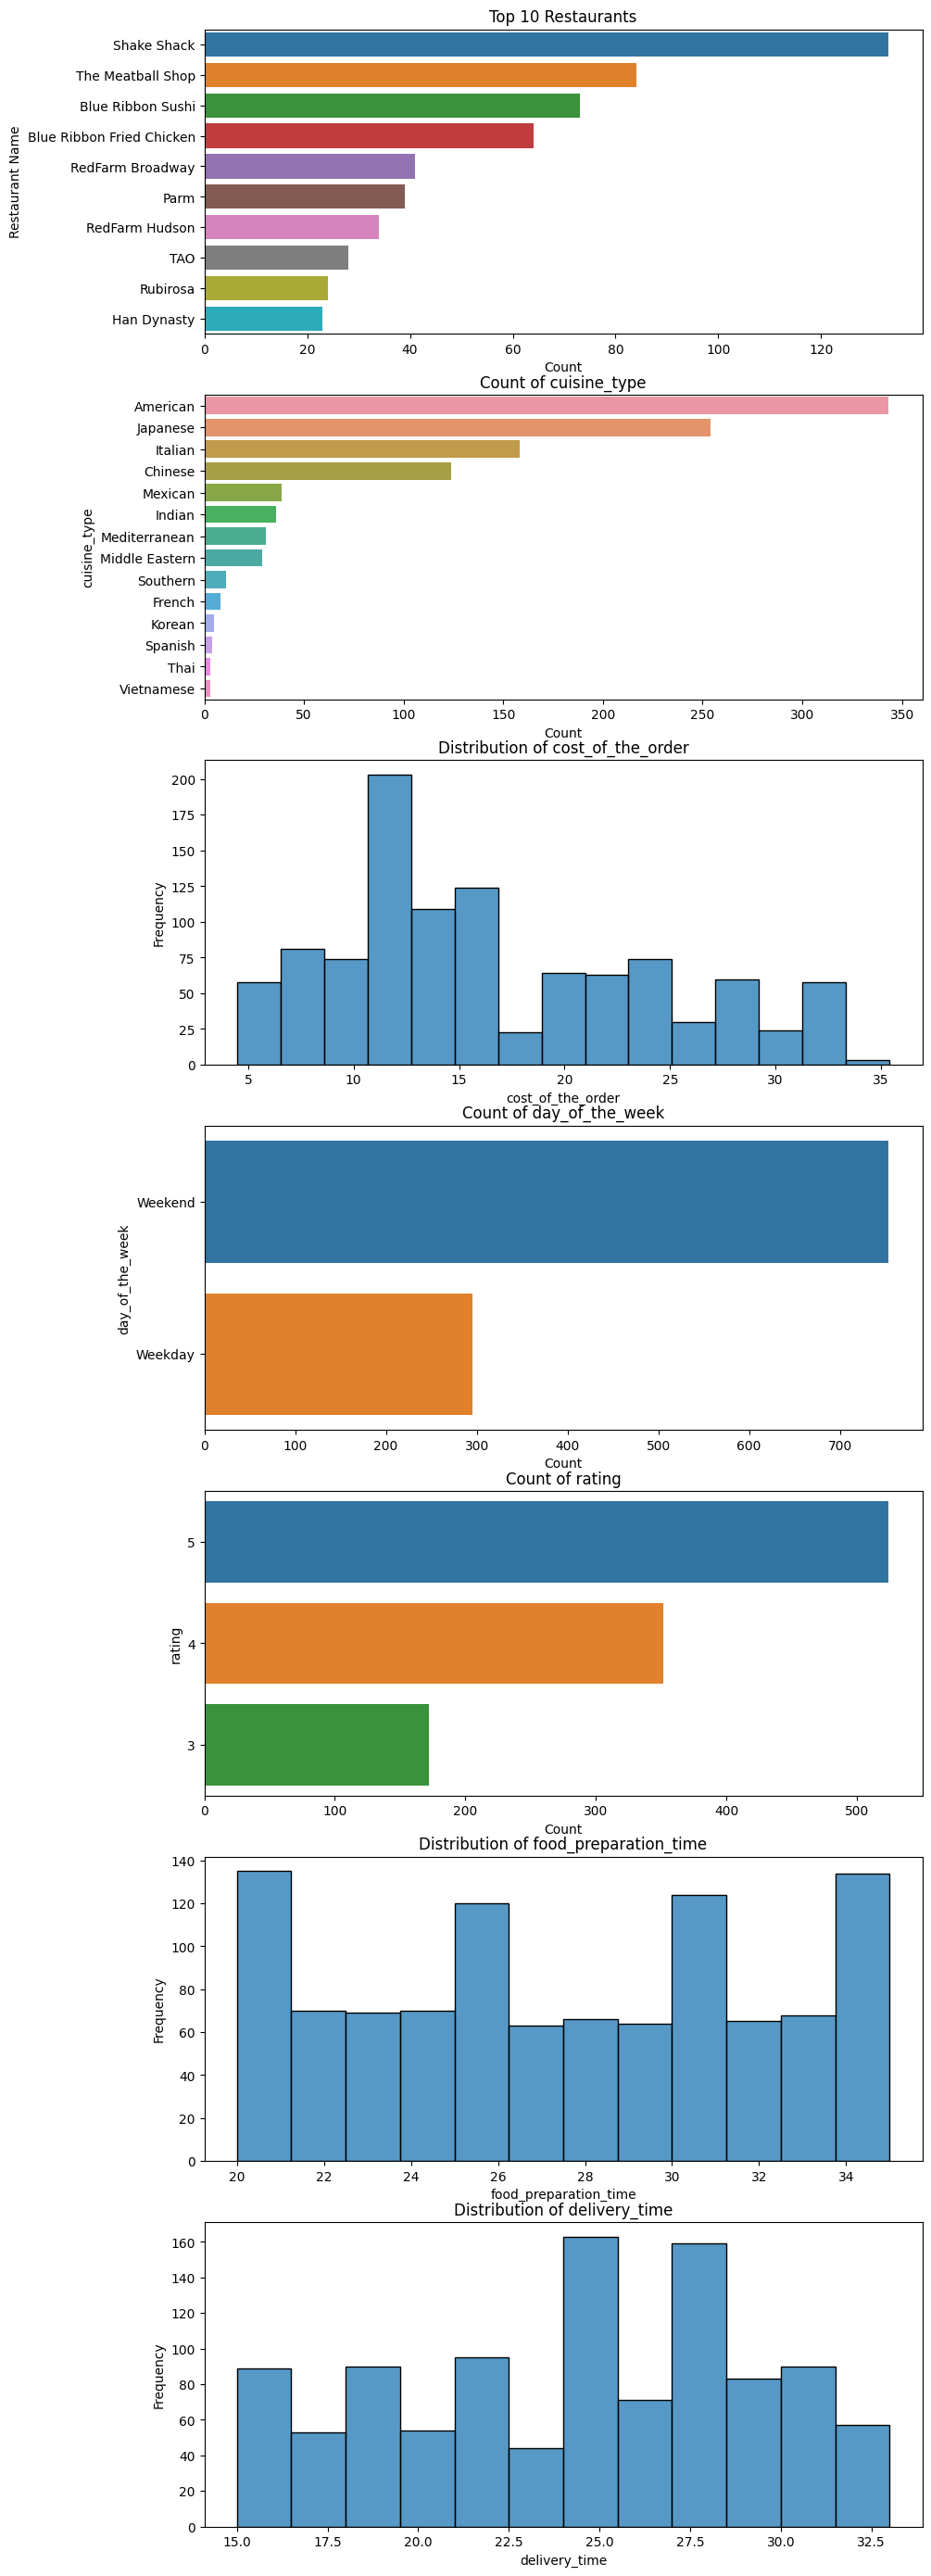

In [23]:
fig, axes = plt.subplots(7, 1, figsize=(10,35))
for i, col in enumerate(df.columns):
    ax = axes[i]

    if df[col].dtype in ['int64', 'float64']:
        sns.histplot(df[col], ax=ax )
        ax.set_title(f'Distribution of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')

    elif col == 'restaurant_name':
        top_10 = df[col].value_counts().nlargest(10)
        sns.barplot(x=top_10.values, y=top_10.index, ax=ax)
        ax.set_title('Top 10 Restaurants')
        ax.set_xlabel('Count')
        ax.set_ylabel('Restaurant Name')

    elif col in cat:
        sns.countplot(data=df, y=col, ax=ax ,order = df[col].value_counts().index)
        ax.set_title(f'Count of {col}')
        ax.set_xlabel('Count')
        ax.set_ylabel(col)

Identified outliers :

In [24]:
df.describe()

,cost_of_the_order,food_preparation_time,delivery_time
count,1048.000000,1048.000000,1048.000000
mean,16.787080,27.459924,24.101145
std,7.579964,4.653651,4.926904
min,4.470000,20.000000,15.000000
25%,12.130000,23.000000,20.000000
50%,14.725000,27.000000,25.000000
75%,22.750000,32.000000,28.000000
max,35.410000,35.000000,33.000000


In [10]:
df['rating'] = df['rating'].astype(int)

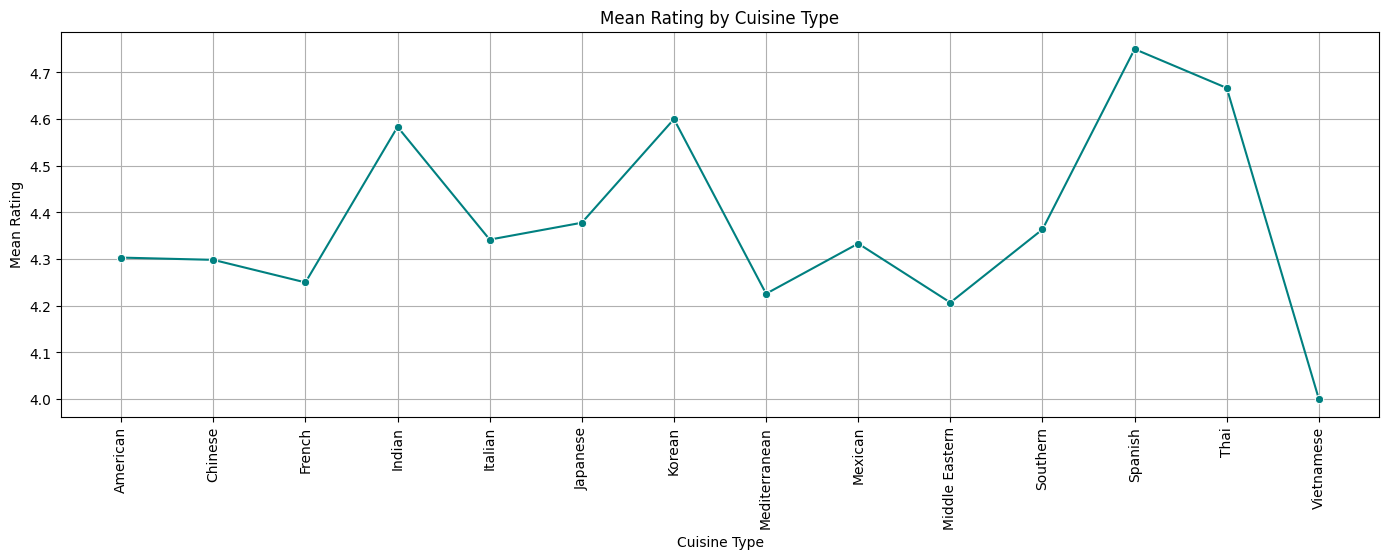

In [26]:
df_mean = df.groupby('cuisine_type')['rating'].mean().reset_index()
plt.figure(figsize=(17, 5))
sns.lineplot(data=df_mean, x='cuisine_type', y='rating', marker='o',color='teal')
plt.xticks(rotation=90)
plt.xlabel('Cuisine Type')
plt.ylabel('Mean Rating')
plt.title('Mean Rating by Cuisine Type')
plt.grid(True)

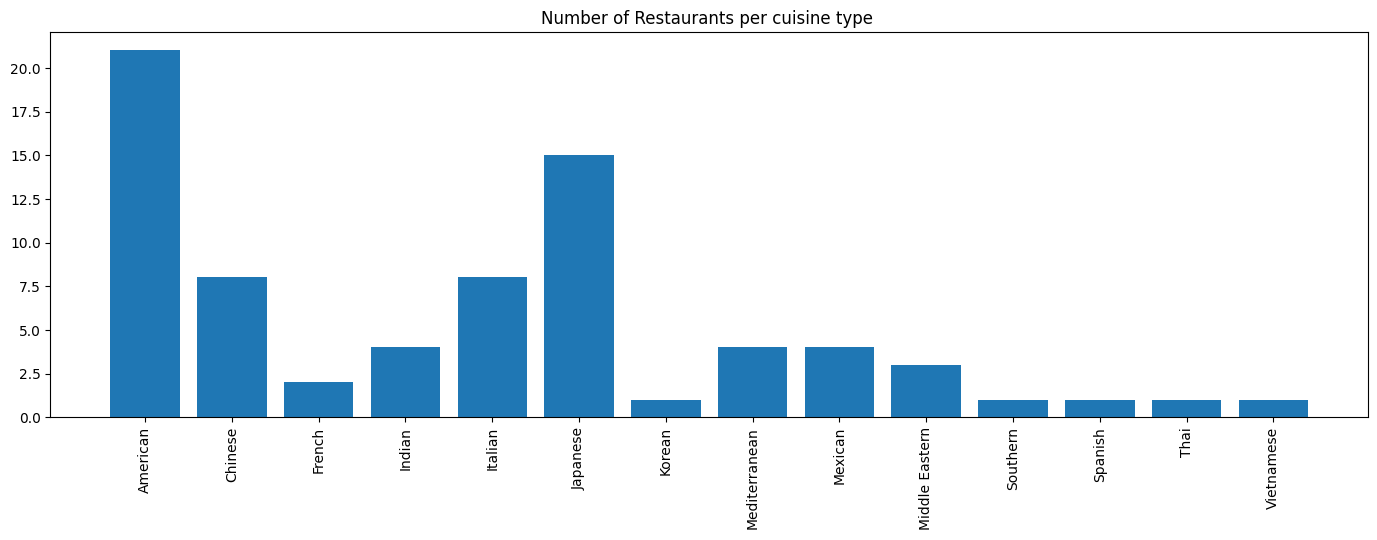

In [27]:
gp = df.groupby('cuisine_type')['restaurant_name'].nunique().reset_index()
plt.figure(figsize=(17, 5))
plt.bar(gp['cuisine_type'], gp['restaurant_name'])
plt.title('Number of Restaurants per cuisine type ')
plt.xticks(rotation=90);

* Both graphs show that Spanish food gets the best ratings, followed by Thai and Korean. Vietnamese food has the lowest ratings. Even though American food is 3 times popular as chinese cuisine rating, its ratings are simular.

🍀  Part 4

In [28]:
df.head()

,restaurant_name,cuisine_type,cost_of_the_order,day_of_the_week,rating,food_preparation_time,delivery_time
2,Cafe Habana,Mexican,12.23,Weekday,5,23,28
3,Blue Ribbon Fried Chicken,American,29.20,Weekend,3,25,15
5,Tamarind TriBeCa,Indian,25.22,Weekday,3,20,24
7,Barbounia,Mediterranean,5.97,Weekday,3,33,30
11,Empanada Mama (closed),Mexican,8.10,Weekend,5,23,22


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048 entries, 2 to 1896
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   restaurant_name        1048 non-null   object 
 1   cuisine_type           1048 non-null   object 
 2   cost_of_the_order      1048 non-null   float64
 3   day_of_the_week        1048 non-null   object 
 4   rating                 1048 non-null   int64  
 5   food_preparation_time  1048 non-null   int64  
 6   delivery_time          1048 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 65.5+ KB


In [21]:
def evaluate_classification(y_true, y_predicted, average=None):
  accuracy = accuracy_score(y_true, y_predicted)
  recall = recall_score(y_true, y_predicted, average=average)
  precision = precision_score(y_true, y_predicted, average=average)
  f1 = f1_score(y_true, y_predicted, average=average)

  print(f'Accuracy: {accuracy:.3f} \nRecall: {recall:.3f} \nPrecision: {precision:.3f} \nF1 Score: {f1:.3f}')

In [11]:
df['rating'].replace([3,4,5],[0,1,2], inplace=True)

In [12]:
X = df.drop(columns='rating')
y = df['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42 , test_size=0.3)

In [13]:
num_cols = ['cost_of_the_order','food_preparation_time','delivery_time']
nom_cols = ['restaurant_name','cuisine_type','day_of_the_week']

In [14]:
#Numeric
scaler = StandardScaler()

#ordinal
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

#Tuples
num_tuple = ('numeric', scaler, num_cols)
nom_tuple = ('Nominal', ohe_encoder, nom_cols)

In [15]:
preprocessor = ColumnTransformer([num_tuple, nom_tuple,],
                                    remainder='passthrough',
                                    verbose_feature_names_out=False)

In [16]:
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

PCA

In [17]:
pca_preprocessor = make_pipeline(StandardScaler(), PCA(n_components=0.90))
X_train_0 = pca_preprocessor.fit_transform(X_train_proc)
X_test_0 = pca_preprocessor.transform(X_test_proc)

In [18]:
# Conversion
X_train_pca = pd.DataFrame(data = X_train_0)
X_test_pca = pd.DataFrame(data = X_test_0)

KNN

In [19]:
knn = KNeighborsClassifier()
knn.fit(X_train_pca, y_train)
train_preds = knn.predict(X_train_pca)
test_preds = knn.predict(X_test_pca)

In [22]:
print('Training Metrics\n')
evaluate_classification(y_train, train_preds, average='macro')
print('\n')
print('Testing Metrics\n')
evaluate_classification(y_test, test_preds, average='macro')

Training Metrics

Accuracy: 0.603 
Recall: 0.575 
Precision: 0.569 
F1 Score: 0.572


Testing Metrics

Accuracy: 0.375 
Recall: 0.308 
Precision: 0.315 
F1 Score: 0.309


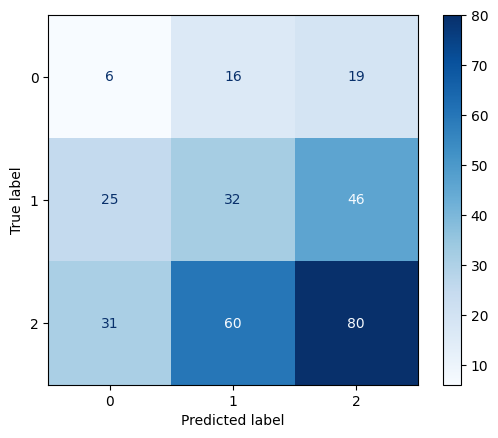

In [23]:
ConfusionMatrixDisplay.from_estimator(knn, X_test_pca, y_test, cmap = 'Blues');

In [24]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [25]:
param = {'n_neighbors': range(5,20),
              'p': range(1,10),
              'weights': ['distance','uniform']}

* GridSearchCV

In [26]:
knn_gs = GridSearchCV(knn, param)
knn_gs.fit(X_train_pca, y_train)
print('Best KNN Parameters:')
print(knn_gs.best_params_)
best_knn = knn_gs.best_estimator_
print(f'Accuracy of best KNN model is: {best_knn.score(X_test_pca, y_test)}')

Best KNN Parameters:
{'n_neighbors': 19, 'p': 1, 'weights': 'uniform'}
Accuracy of best KNN model is: 0.49206349206349204


⛺ XGBoost

In [27]:
xgb = XGBClassifier()
xgb.fit(X_train_pca, y_train)
train_preds = xgb.predict(X_train_pca)
test_preds = xgb.predict(X_test_pca)
print('Training accuracy:', accuracy_score(y_train,train_preds))
print('Testing accuracy:', accuracy_score(y_test, test_preds))

Training accuracy: 1.0
Testing accuracy: 0.4253968253968254


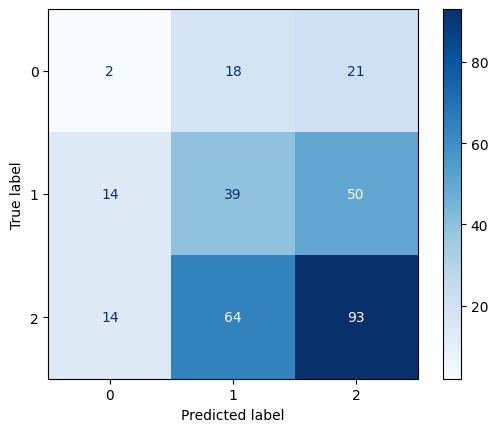

In [28]:
ConfusionMatrixDisplay.from_estimator(xgb, X_test_pca, y_test, cmap = 'Blues');

🌌 RandomForest

In [29]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train_pca, y_train)
train_preds_rf = rf.predict(X_train_pca)
test_preds_rf = rf.predict(X_test_pca)

In [30]:
print('Training Metrics\n')
evaluate_classification(y_train, train_preds_rf, average='macro')
print('\n')
print('Testing Metrics\n')
evaluate_classification(y_test, test_preds_rf, average='macro')

Training Metrics

Accuracy: 1.000 
Recall: 1.000 
Precision: 1.000 
F1 Score: 1.000


Testing Metrics

Accuracy: 0.422 
Recall: 0.320 
Precision: 0.319 
F1 Score: 0.319


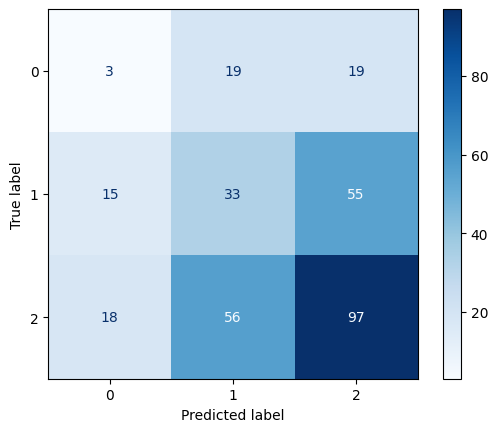

In [31]:
ConfusionMatrixDisplay.from_estimator(rf, X_test_pca, y_test, cmap = 'Blues');

GridShearchCV

In [32]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [35]:
param_2 = {'n_estimators': [50, 100],
                    'max_depth': [5, 10, 20],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4]}

In [36]:
rf_gs = GridSearchCV(rf, param_2)
rf_gs.fit(X_train_pca, y_train)
print('Best RFC Parameters:')
print(rf_gs.best_params_)
best_rf = rf_gs.best_estimator_
print(f'Accuracy of best RFC model is: {best_rf.score(X_test_pca, y_test)}')

Best RFC Parameters:
{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy of best RFC model is: 0.5079365079365079


RandomizedSearchCV

In [38]:
rf_rs = RandomizedSearchCV(rf, param_2, n_iter=10, random_state=42)
rf_rs.fit(X_train_pca, y_train)
print('Best RFC Parameters:')
print(rf_rs.best_params_)
best_rf_rs = rf_rs.best_estimator_
print(f'Accuracy of best RFC model is: {best_rf_rs.score(X_test_pca, y_test)}')

Best RFC Parameters:
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5}
Accuracy of best RFC model is: 0.5047619047619047


SMOTE

In [41]:
smote = SMOTE()
X_train_s, y_train_s = smote.fit_resample(X_train_proc, y_train)

In [42]:
rf_s = RandomForestClassifier(max_depth = 5, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 100)
rf_s.fit(X_train_s, y_train_s)

RandomForestClassifier(max_depth=5)

In [44]:
test_preds = rf_s.predict(X_test_proc)

              precision    recall  f1-score   support

           0       0.09      0.17      0.12        41
           1       0.32      0.34      0.33       103
           2       0.61      0.46      0.52       171

    accuracy                           0.38       315
   macro avg       0.34      0.32      0.32       315
weighted avg       0.45      0.38      0.41       315



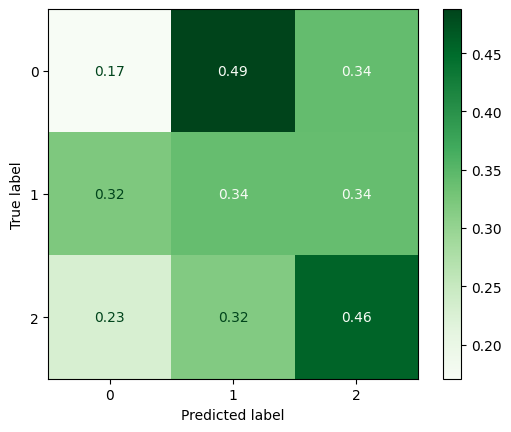

In [45]:
print(classification_report(y_test, test_preds))
ConfusionMatrixDisplay.from_predictions(y_test, test_preds,normalize='true',cmap='Greens');